In [5]:
from cbers4asat import Cbers4aAPI
from datetime import date
import geopandas as gpd
import pandas as pd
from cbers4asat.tools import rgbn_composite
from glob import glob
import matplotlib.pyplot as plt
from os.path import basename

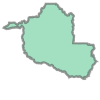

In [6]:
ro = gpd.read_file("./limite_ro/limite_ro.shp")

ro_geometry = ro.unary_union

ro_geometry

In [7]:
inicio = date(2020, 6, 1)
fim = date(2022, 10, 31)

api = Cbers4aAPI("teste@teste.com")

produtos = api.query(location=ro_geometry,
                     initial_date=inicio,
                     end_date=fim,
                     cloud=50,
                     limit=1000,
                     collections=["CBERS4A_WPM_L4_DN"]
                     )

gdf = api.to_geodataframe(produtos)

gdf

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,eo:bands
CBERS4A_WPM22612320221022,"POLYGON ((-62.17520 -7.43491, -62.17310 -8.483...",2022-10-22T14:50:40,226,123,CBERS4A,WPM,40.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712920221017,"POLYGON ((-64.03390 -12.19480, -64.03810 -13.2...",2022-10-17T14:55:24,227,129,CBERS4A,WPM,40.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712820221017,"POLYGON ((-63.86440 -11.40150, -63.86770 -12.4...",2022-10-17T14:55:11,227,128,CBERS4A,WPM,50.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712720221017,"POLYGON ((-63.69570 -10.60890, -63.69820 -11.6...",2022-10-17T14:54:58,227,127,CBERS4A,WPM,30.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712620221017,"POLYGON ((-63.52750 -9.81558, -63.52930 -10.86...",2022-10-17T14:54:45,227,126,CBERS4A,WPM,50.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
...,...,...,...,...,...,...,...,...,...,...
CBERS4A_WPM22712920200601,"POLYGON ((-64.00500 -12.19370, -64.00500 -13.2...",2020-06-01T14:43:46,227,129,CBERS4A,WPM,30.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712820200601,"POLYGON ((-63.83360 -11.40070, -63.83360 -12.4...",2020-06-01T14:43:33,227,128,CBERS4A,WPM,30.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712520200601,"POLYGON ((-63.32410 -9.02052, -63.32410 -10.06...",2020-06-01T14:42:55,227,125,CBERS4A,WPM,30.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."
CBERS4A_WPM22712420200601,"POLYGON ((-63.15570 -8.22661, -63.15570 -9.275...",2020-06-01T14:42:42,227,124,CBERS4A,WPM,10.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name..."


<Axes: >

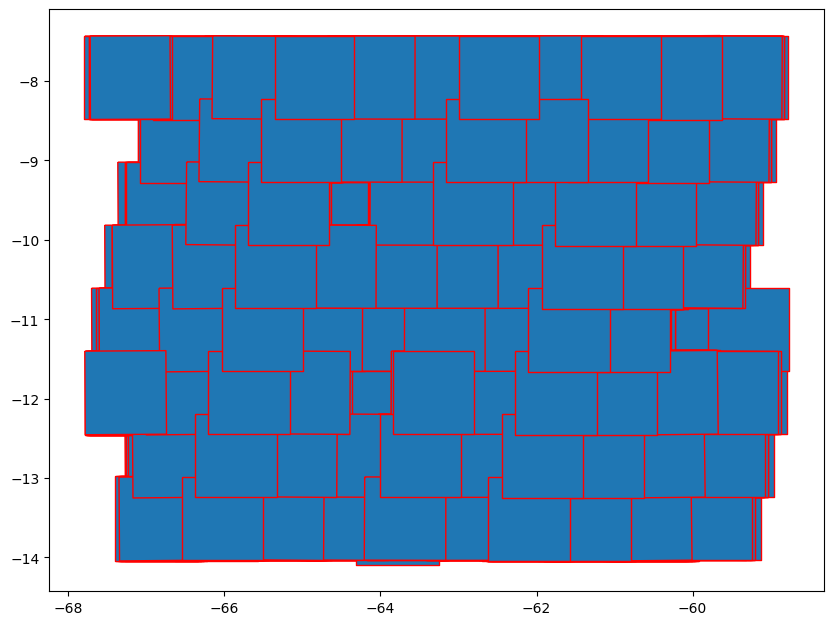

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ro.plot(ax=ax, color='yellow')
gdf.plot(ax=ax, color=None, edgecolor='red')

<Axes: >

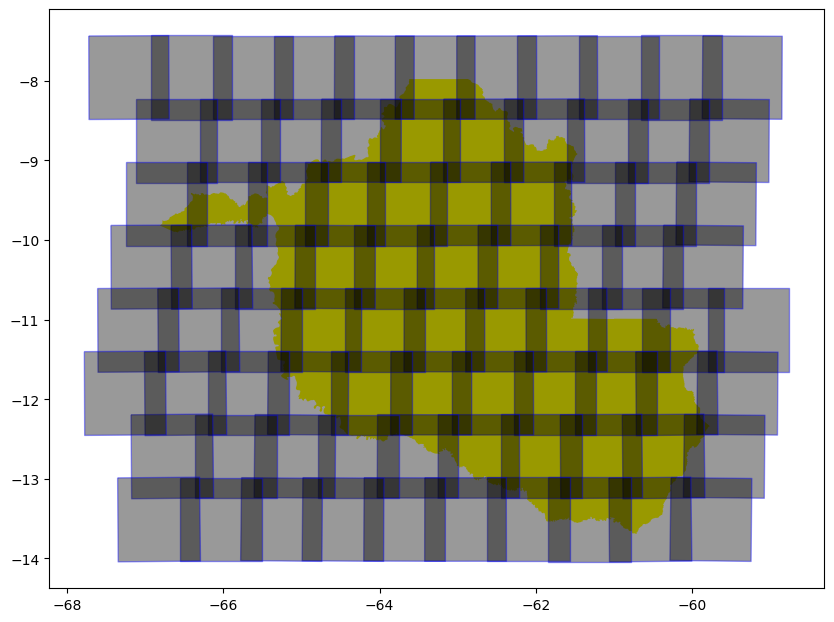

In [9]:
mosaic = gpd.GeoDataFrame()

for group_name, dframe in gdf.groupby(by=['path', 'row']):
    img = dframe.loc[ (dframe.cloud_cover == dframe.cloud_cover.min()) ]

    img = img.loc [(img.datetime == img.datetime.min())]

    mosaic = pd.concat([mosaic, img])

fig, ax = plt.subplots(figsize=(10, 10))
ro.plot(ax=ax, color="yellow")
mosaic.plot(ax=ax, facecolor="black", edgecolor='blue', alpha=0.4)

In [10]:
mosaic.to_crs(epsg=4674, inplace=True)

mosaic.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
mosaicos_dentro_estado = mosaic.geometry.apply(lambda g: ro.intersects(g))

ro_mosaic = mosaic.merge(right=mosaicos_dentro_estado, left_index=True, right_index=True)\
    .rename(columns={0: 'intersects'})

ro_mosaic = ro_mosaic.loc[ro_mosaic['intersects'] == True]

ro_mosaic.head()

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,eo:bands,intersects
CBERS4A_WPM22212820200727,"POLYGON ((-59.93190 -11.40010, -59.94310 -12.4...",2020-07-27T14:29:44,222,128,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22212920200727,"POLYGON ((-60.10190 -12.19280, -60.11460 -13.2...",2020-07-27T14:29:57,222,129,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22213020200727,"POLYGON ((-60.27260 -12.98550, -60.28690 -14.0...",2020-07-27T14:30:09,222,130,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22312720220805,"POLYGON ((-60.64000 -10.60030, -60.64000 -11.6...",2022-08-05T14:42:55,223,127,CBERS4A,WPM,10.0,NaN,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True
CBERS4A_WPM22312820200621,"POLYGON ((-60.72510 -11.40340, -60.71630 -12.4...",2020-06-21T14:31:43,223,128,CBERS4A,WPM,0.0,0.0,-1,"[{'name': 'pan', 'common_name': 'pan'}, {'name...",True


<Axes: >

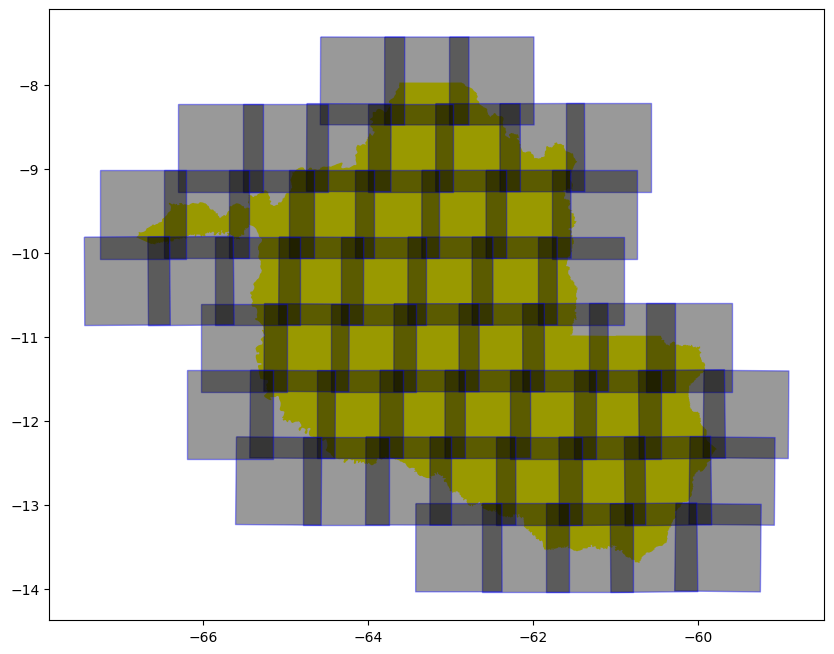

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

ro.plot(ax=ax, color="yellow")

ro_mosaic.plot(ax=ax, facecolor="black", edgecolor='blue', alpha=0.4)

In [13]:
ro_mosaic.drop(columns=['eo:bands'], inplace=True)

In [14]:
ro_mosaic.to_file("mosaico_cbers4a_ro.geojson", driver='GeoJSON')

In [16]:
ro_mosaic.head()

,geometry,datetime,path,row,satellite,sensor,cloud_cover,sync_loss,eo:gsd,intersects
CBERS4A_WPM22212820200727,"POLYGON ((-59.93190 -11.40010, -59.94310 -12.4...",2020-07-27T14:29:44,222,128,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22212920200727,"POLYGON ((-60.10190 -12.19280, -60.11460 -13.2...",2020-07-27T14:29:57,222,129,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22213020200727,"POLYGON ((-60.27260 -12.98550, -60.28690 -14.0...",2020-07-27T14:30:09,222,130,CBERS4A,WPM,0.0,0.0,-1,True
CBERS4A_WPM22312720220805,"POLYGON ((-60.64000 -10.60030, -60.64000 -11.6...",2022-08-05T14:42:55,223,127,CBERS4A,WPM,10.0,NaN,-1,True
CBERS4A_WPM22312820200621,"POLYGON ((-60.72510 -11.40340, -60.71630 -12.4...",2020-06-21T14:31:43,223,128,CBERS4A,WPM,0.0,0.0,-1,True


In [30]:
api.download(ro_mosaic, bands=['red', 'nir', 'green'], outdir="imagens", with_folder=True)

In [2]:
for dirs in glob("./imagens/*"):
    red, green, blue = '', '', ''
    img_name = ''
    for file in glob(f"{dirs}/*.tif"):
        img_name = basename(file)[:-10]
        if 'BAND3' in file:
            red = file
        elif 'BAND4' in file:
            green = file
        elif 'BAND2' in file:
            blue = file

    rgbn_composite(red=red, green=green, blue=blue, outdir='mosaico_partes', filename=f'{img_name}.tif')